In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patheffects as PathEffects

from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

In [2]:
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [3]:
#Read the PSF size in the FORS2 images.
seeing_tab = Table.read("../../Resolved_Polarization_v3/All_seeing_values.txt", format='ascii')
seeing_tab.rename_column("col1", "WID")
seeing_tab.rename_column("col2", "Band")
seeing_tab.rename_column("col3", "FWHM")
seeing_tab.rename_column("col4", "filename")

In [4]:
seeing = dict()
seeing['FORS2'] = np.max(seeing_tab['FWHM'][seeing_tab['WID']=="W0204-0506"])*u.arcsec
seeing['F555W'] = 0.067*u.arcsec
seeing['F160W'] = 0.148*u.arcsec
print(seeing)

{'FORS2': <Quantity 0.86 arcsec>, 'F555W': <Quantity 0.067 arcsec>, 'F160W': <Quantity 0.148 arcsec>}


In [5]:
#Read all the images we will plot. 
pfrac = fits.open("../../Resolved_Polarization_v3/stamps/W0204-0506.R_SPECIAL.All.pfrac.fits")
pangle = fits.open("../../Resolved_Polarization_v3/stamps/W0204-0506.R_SPECIAL.All.pangle.fits")
stack = fits.open("../../Resolved_Polarization_v3/stamps/W0204-0506.R_SPECIAL.All.stack.fits")
fors2 = fits.open("../../HST/W0204/fors2.cutout.fits")
f160w = fits.open("../../HST/W0204/F160W.cutout.fits")
f555w = fits.open("../../HST/W0204/F555W.cutout.fits")

In [6]:
#Transform pfrac into percentage. 
pfrac[0].data *= 100

In [7]:
#Read the WCS from all the images that have one. 
fors2_wcs = WCS(fors2[0].header)
f160w_wcs = WCS(f160w[0].header)
f555w_wcs = WCS(f555w[0].header)

In [8]:
#All the cutouts have the same angular size and are aligned, but do not have the same pixel size. All the FORS2 cutouts do, however. We'll take the central pixel from the FORS2 data to set the coordinates references, and then we will do 5x5 arcsecond cutouts. 
px = (fors2[0].header['NAXIS1']-1)/2
py = (fors2[0].header['NAXIS2']-1)/2
f_center = fors2_wcs.pixel_to_world(px,py)

#Move the center 0.5" to the west. 
c_center = f_center.directional_offset_by(90*u.deg, -0.5*u.arcsec)

#cutout_size = 22 * fors2_wcs.proj_plane_pixel_scales()[0]
cutout_size = 3.*u.arcsec
size = (cutout_size, 1.15*cutout_size)
pfrac_co  = Cutout2D(pfrac[0].data , c_center, size=size, wcs=fors2_wcs)
pangle_co = Cutout2D(pangle[0].data, c_center, size=size, wcs=fors2_wcs)
stack_co  = Cutout2D(stack[0].data , c_center, size=size, wcs=fors2_wcs)
f160w_co  = Cutout2D(f160w[0].data , c_center, size=size, wcs=f160w_wcs)
f555w_co  = Cutout2D(f555w[0].data , c_center, size=size, wcs=f555w_wcs)

In [9]:
#We'll put a cross in the brightest pixel of the F160W image. 
max_pix = np.unravel_index(f160w_co.data.argmax(), f160w_co.data.shape)
max_coords = f160w_co.wcs.pixel_to_world(max_pix[1],max_pix[0])

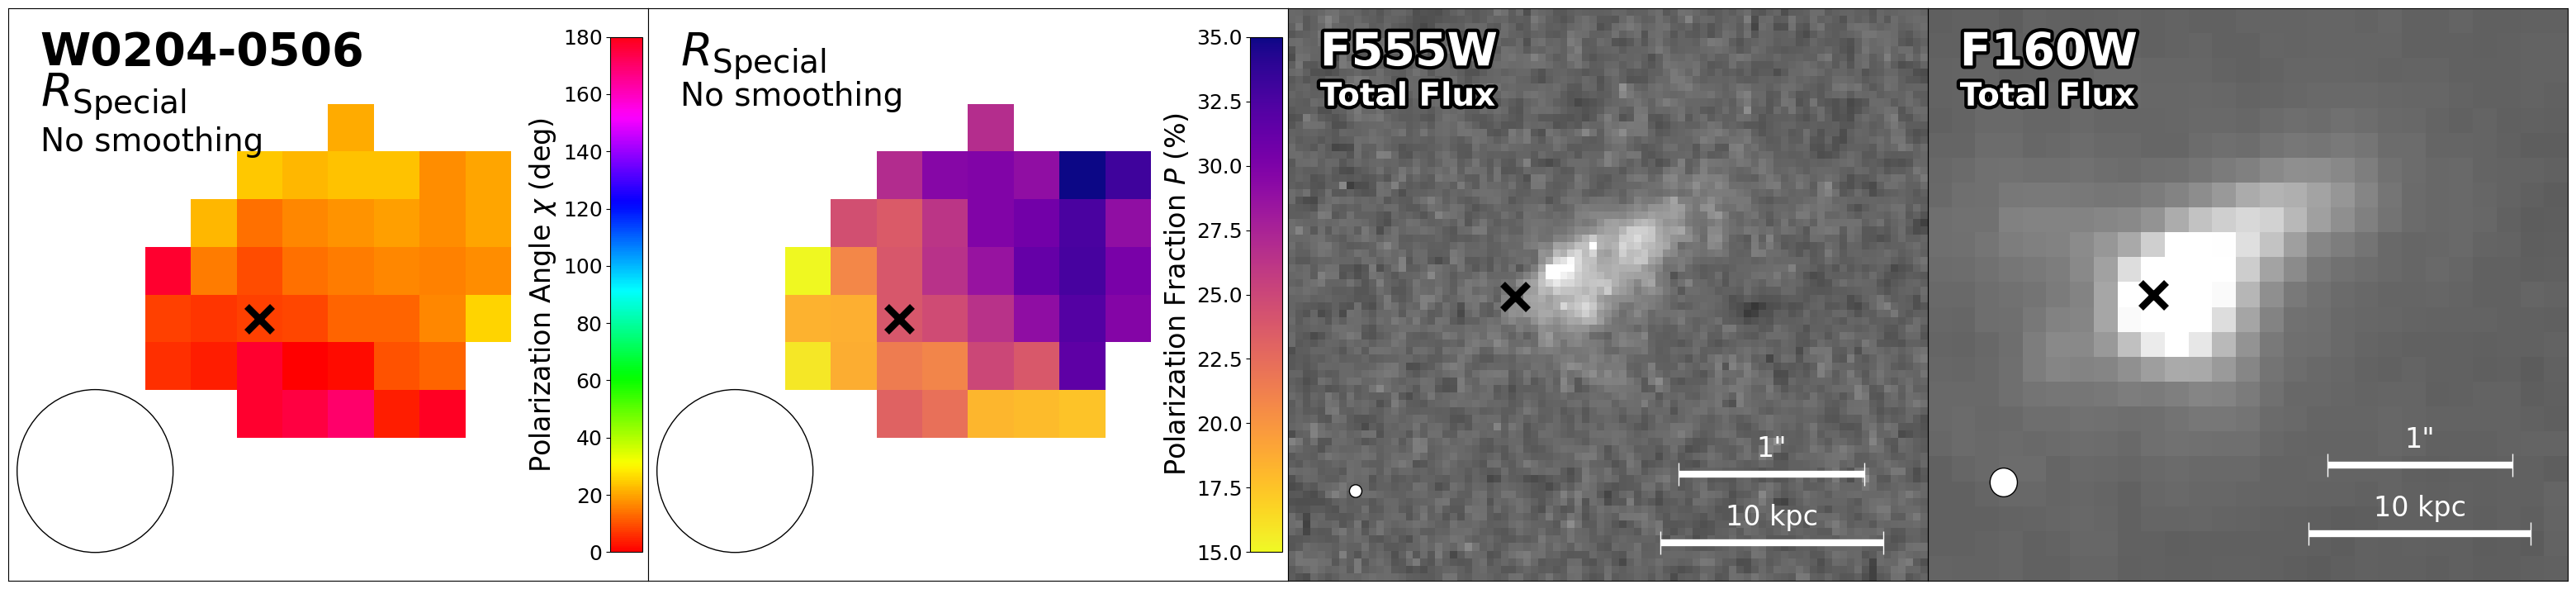

In [10]:
#Now, plot the panels. 
fig, axs = plt.subplots(1,4, figsize=(40,9), squeeze=False)
plt.subplots_adjust(wspace=0., hspace=0.)
for ax in axs.flat:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

#Get the RMS of the stack pol image and generate a mask for the pfrac and pangle images.
_, _, rms = sigma_clipped_stats(stack[0].data, sigma=3.0)
mask = np.where(stack_co.data<5.0*rms, True, False)
pangle_co.data[mask] = np.nan
pfrac_co.data[mask] = np.nan

#Plot the images.
cm_pa = axs[0,0].imshow(pangle_co.data, vmin=0., vmax=180., cmap='hsv', origin='lower', aspect='auto')

cm_pf = axs[0,1].imshow(pfrac_co.data, vmin=15., vmax=35., cmap='plasma_r', origin='lower', aspect='auto')

norm_f555w = ImageNormalize(f555w_co.data, stretch=LinearStretch(), interval=ZScaleInterval(), vmin=-0.05, vmax=0.08)
axs[0,2].imshow(f555w_co.data, norm=norm_f555w, cmap='gray', origin='lower', aspect='auto')

norm_f160w = ImageNormalize(f160w_co.data, stretch=LinearStretch(), interval=ZScaleInterval(), vmin=-1.2, vmax=2.0)
axs[0,3].imshow(f160w_co.data, norm=norm_f160w, cmap='gray', origin='lower', aspect='auto')

#Add the colorbars to the polarization panels.
for k, cm in enumerate([cm_pa, cm_pf]):
    if k==0:
        label = r'Polarization Angle $\chi~(\rm deg)$'
    else:
        label = r'Polarization Fraction $P~(\%)$'
    cax = inset_axes(axs[0,k], width="5%", height="90%", loc='center right') 
    cbar = fig.colorbar(cm, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label=label, fontsize=24)
    cax.yaxis.set_ticks_position('left')
    cax.yaxis.set_label_position('left')

#Draw an x at the position of the brightest pixel in F160W.
for k, im in enumerate([pangle_co, pfrac_co, f555w_co, f160w_co]):
    #cx, cy = im.wcs.world_to_pixel(f_center)
    cx, cy = im.wcs.world_to_pixel(max_coords)
    axs[0,k].scatter([cx], [cy], color='black', marker='x', s=500, lw=6.0)

#Object label
axs[0,0].text(0.05, 0.9, "W0204-0506", transform=axs[0,0].transAxes, fontsize=40, weight='bold')

#Add the bands.
for k, bandname in enumerate([r'$R_{\rm Special}$', r'$R_{\rm Special}$', r'F555W', r'F160W']):
    if k<2:
        color = 'black'
    else:
        color = 'white'
    if k==0:
        x, y = 0.05, 0.83
    else:
        x, y = 0.05, 0.9
    txt = axs[0,k].text(x, y, bandname, transform=axs[0,k].transAxes, fontsize=40, weight='bold', color=color)
    if k>=2:
        txt.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='black')])

#Add a label to say no smoothing is applied in the R_special bands. 
for k in range(2):
    x, y = 0.05, 0.83
    if k==0:
        x, y = 0.05, 0.75
    txt = axs[0,k].text(x, y, 'No smoothing', transform=axs[0,k].transAxes, fontsize=28, color='black')

#Add a label to show the HST panels show total flux. 
for k in range(2,4):
    txt = axs[0,k].text(0.05, 0.83, 'Total Flux', transform=axs[0,k].transAxes, fontsize=28, weight='bold', color='white')
    txt.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='black')])

#Beam size
for k, inst in enumerate(['FORS2','FORS2','F555W','F160W']):
    if inst=='FORS2':
        im = stack_co
    elif inst=='F555W':
        im = f555w_co
    elif inst=='F160W':
        im = f160w_co
    ny, nx = im.data.shape
    pixscale = im.wcs.proj_plane_pixel_scales()[0]
    beam  = plt.Circle((nx*0.10,ny*0.15),(seeing[inst]/2/pixscale).to(u.dimensionless_unscaled), color='k', fill=True, fc='white')
    axs[0,k].add_patch(beam)


#10kpc bar
for k, im in enumerate([pangle_co, pfrac_co, f555w_co, f160w_co]):
    if k<2:
        continue
    if k<2:
        color = 'black'
    else:
        color = 'white'
    pixscale = im.wcs.proj_plane_pixel_scales()[0]
    bar_size = (10*u.kpc/cosmo.angular_diameter_distance(2.100))*u.rad
    bar_size_pix = (bar_size / pixscale).to(u.dimensionless_unscaled)
    ny, nx = im.data.shape
    axs[0,k].errorbar([0.75*nx],[0.06*ny],xerr=[bar_size_pix/2.], fmt='none', capsize=10.0,lw=6.0,color=color)
    txt = axs[0,k].text(0.75*nx,0.08*ny,"10 kpc",ha='center',va='bottom', fontsize=24, color=color)
    if k<2:
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='black')])

    ang_bar_size = 1.0*u.arcsec
    ang_bar_size_pix = (ang_bar_size / pixscale).to(u.dimensionless_unscaled)
    axs[0,k].errorbar([0.75*nx],[0.18*ny],xerr=[ang_bar_size_pix/2.], fmt='none', capsize=10.0,lw=6.0,color=color)
    txt = axs[0,k].text(0.75*nx,0.20*ny,"1\"",ha='center',va='bottom', fontsize=24, color=color)
    if k<2:
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='black')])

#plt.tight_layout()
plt.show()

fig.savefig("W0204_pol_HST.png", dpi=200, bbox_inches='tight')

24706.653137207035 840.5392165139572 0.17010382018278014


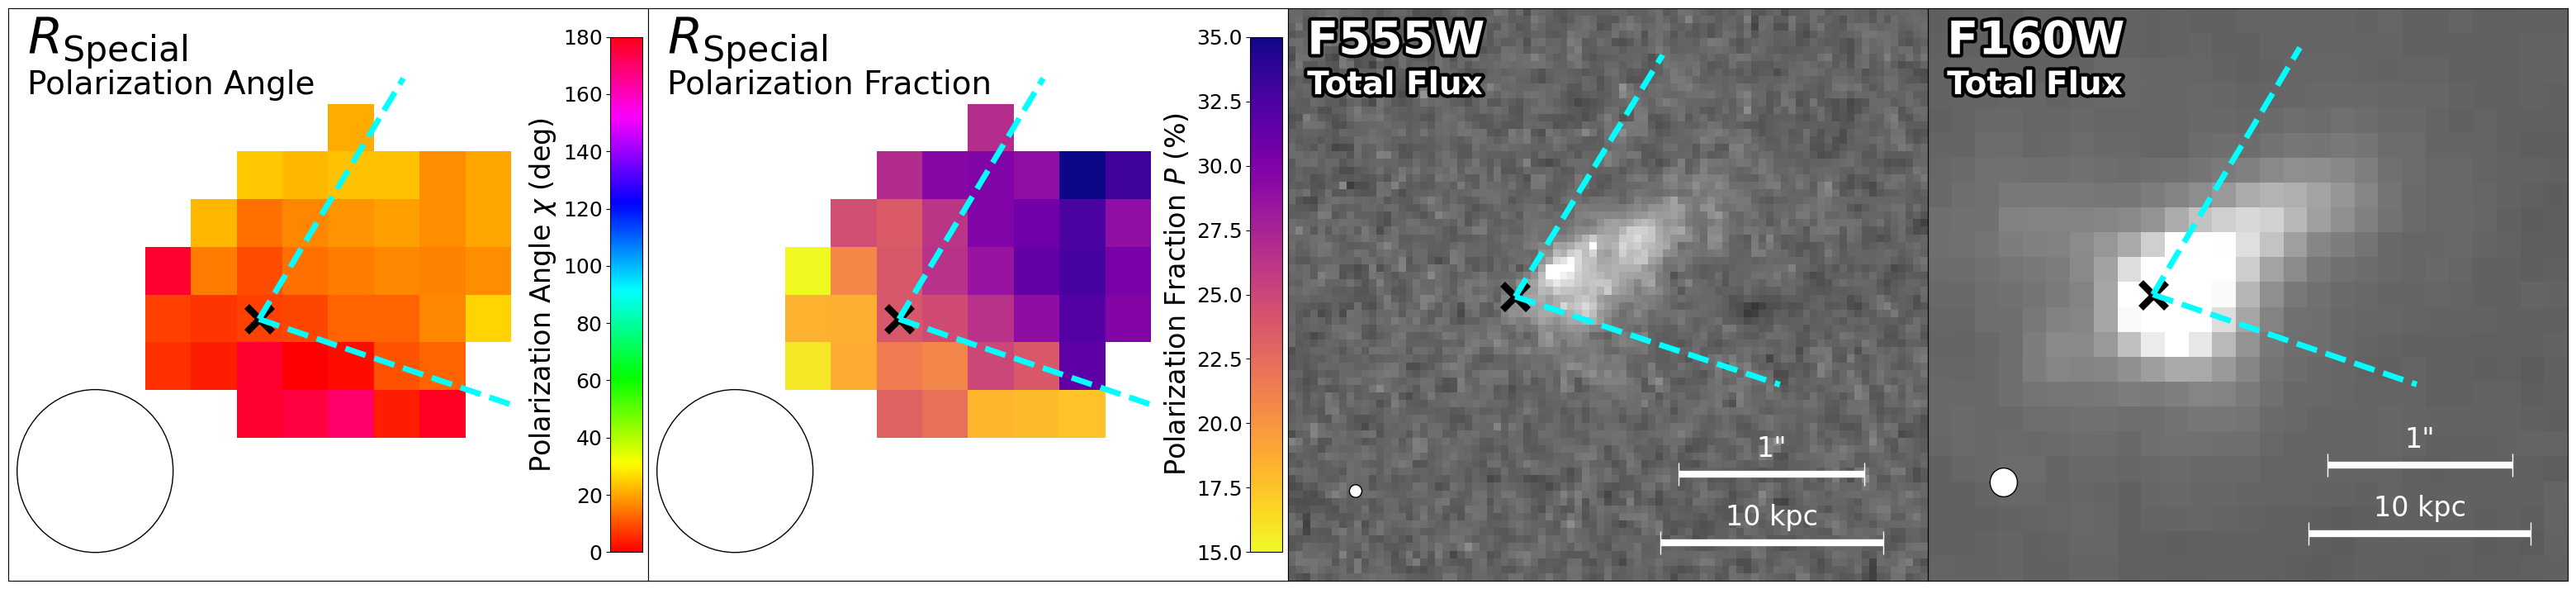

In [13]:
#Now, plot the panels. 
fig, axs = plt.subplots(1,4, figsize=(40,9), squeeze=False)
plt.subplots_adjust(wspace=0., hspace=0.)
for ax in axs.flat:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

#Get the RMS of the stack pol image and generate a mask for the pfrac and pangle images.
_, _, rms = sigma_clipped_stats(stack[0].data, sigma=3.0)
print(stack_co.data.max(), rms, 5*rms/stack_co.data.max())
mask = np.where(stack_co.data<5.0*rms, True, False)
pangle_co.data[mask] = np.nan
pfrac_co.data[mask] = np.nan

#Plot the images.
cm_pa = axs[0,0].imshow(pangle_co.data, vmin=0., vmax=180., cmap='hsv', origin='lower', aspect='auto')

cm_pf = axs[0,1].imshow(pfrac_co.data, vmin=15., vmax=35., cmap='plasma_r', origin='lower', aspect='auto')

norm_f555w = ImageNormalize(f555w_co.data, stretch=LinearStretch(), interval=ZScaleInterval(), vmin=-0.05, vmax=0.08)
axs[0,2].imshow(f555w_co.data, norm=norm_f555w, cmap='gray', origin='lower', aspect='auto')

norm_f160w = ImageNormalize(f160w_co.data, stretch=LinearStretch(), interval=ZScaleInterval(), vmin=-1.2, vmax=2.0)
axs[0,3].imshow(f160w_co.data, norm=norm_f160w, cmap='gray', origin='lower', aspect='auto')

#Add the colorbars to the polarization panels.
for k, cm in enumerate([cm_pa, cm_pf]):
    if k==0:
        label = r'Polarization Angle $\chi~(\rm deg)$'
    else:
        label = r'Polarization Fraction $P~(\%)$'
    cax = inset_axes(axs[0,k], width="5%", height="90%", loc='center right') 
    cbar = fig.colorbar(cm, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(label=label, fontsize=24)
    cax.yaxis.set_ticks_position('left')
    cax.yaxis.set_label_position('left')

#Draw an x at the position of the brightest pixel in F160W.
for k, im in enumerate([pangle_co, pfrac_co, f555w_co, f160w_co]):
    #cx, cy = im.wcs.world_to_pixel(f_center)
    cx, cy = im.wcs.world_to_pixel(max_coords)
    axs[0,k].scatter([cx], [cy], color='black', marker='x', s=500, lw=6.0)

    #Draw the cone from the best-fit SKIRTOR model. Where we think we see the outflow cone, the polarization angle is about 20 degrees. The cone base will be at the brightest pixel. 
    chi = 20.*u.deg
    #psi_cone = 18*u.deg
    #psi_cone = 25*u.deg
    psi_cone = 38*u.deg
    cone_len = 1.5*u.arcsec
    cx2, cy2 = im.wcs.world_to_pixel(max_coords.directional_offset_by(chi+psi_cone-90*u.deg, cone_len))
    cx3, cy3 = im.wcs.world_to_pixel(max_coords.directional_offset_by(chi-psi_cone-90*u.deg, cone_len))
    #axs[0,k].plot([cx, cx2], [cy, cy2], color='black', ls='dotted', lw=3)
    #axs[0,k].plot([cx, cx3], [cy, cy3], color='black', ls='dotted', lw=3)
    axs[0,k].plot([cx, cx2], [cy, cy2], color='cyan', ls='dashed', lw=5)
    axs[0,k].plot([cx, cx3], [cy, cy3], color='cyan', ls='dashed', lw=5)

#Object label
#axs[0,0].text(0.05, 0.9, "W0204-0506", transform=axs[0,0].transAxes, fontsize=40, weight='bold')

#Add the bands.
for k, bandname in enumerate([r'$R_{\rm Special}$', r'$R_{\rm Special}$', r'F555W', r'F160W']):
    if k<2:
       color = 'black'
    else:
       color = 'white'
    #color = 'white'
    #if k==0:
    #    x, y = 0.05, 0.83
    #else:
        #x, y = 0.05, 0.9
    x, y = 0.03, 0.92
    fontsize=40
    if k<2:
        fontsize=44
    txt = axs[0,k].text(x, y, bandname, transform=axs[0,k].transAxes, fontsize=fontsize, weight='bold', color=color)
    if k>=2:
        txt.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='black')])

#Add a label to say no smoothing is applied in the R_special bands. 
# for k in range(2):
#     x, y = 0.05, 0.83
#     if k==0:
#         x, y = 0.05, 0.75
#     #txt = axs[0,k].text(x, y, 'No smoothing', transform=axs[0,k].transAxes, fontsize=28, color='black')

axs[0,0].text(0.03, 0.85, 'Polarization Angle', transform=axs[0,0].transAxes, fontsize=28, color='black')
axs[0,1].text(0.03, 0.85, 'Polarization Fraction', transform=axs[0,1].transAxes, fontsize=28, color='black')
#Add a label to show the HST panels show total flux. 
for k in range(2,4):
    txt = axs[0,k].text(0.03, 0.85, 'Total Flux', transform=axs[0,k].transAxes, fontsize=28, weight='bold', color='white')
    txt.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='black')])

#Beam size
for k, inst in enumerate(['FORS2','FORS2','F555W','F160W']):
    if inst=='FORS2':
        im = stack_co
    elif inst=='F555W':
        im = f555w_co
    elif inst=='F160W':
        im = f160w_co
    ny, nx = im.data.shape
    pixscale = im.wcs.proj_plane_pixel_scales()[0]
    beam  = plt.Circle((nx*0.10,ny*0.15),(seeing[inst]/2/pixscale).to(u.dimensionless_unscaled), color='k', fill=True, fc='white')
    axs[0,k].add_patch(beam)


#10kpc bar
for k, im in enumerate([pangle_co, pfrac_co, f555w_co, f160w_co]):
    if k<2:
        continue
    if k<2:
        color = 'black'
    else:
        color = 'white'
    pixscale = im.wcs.proj_plane_pixel_scales()[0]
    bar_size = (10*u.kpc/cosmo.angular_diameter_distance(2.100))*u.rad
    bar_size_pix = (bar_size / pixscale).to(u.dimensionless_unscaled)
    ny, nx = im.data.shape
    axs[0,k].errorbar([0.75*nx],[0.06*ny],xerr=[bar_size_pix/2.], fmt='none', capsize=10.0,lw=6.0,color=color)
    txt = axs[0,k].text(0.75*nx,0.08*ny,"10 kpc",ha='center',va='bottom', fontsize=24, color=color)
    if k<2:
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='black')])

    ang_bar_size = 1.0*u.arcsec
    ang_bar_size_pix = (ang_bar_size / pixscale).to(u.dimensionless_unscaled)
    axs[0,k].errorbar([0.75*nx],[0.18*ny],xerr=[ang_bar_size_pix/2.], fmt='none', capsize=10.0,lw=6.0,color=color)
    txt = axs[0,k].text(0.75*nx,0.20*ny,"1\"",ha='center',va='bottom', fontsize=24, color=color)
    if k<2:
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='black')])

#plt.tight_layout()
plt.show()

fig.savefig("W0204_pol_HST.with_cone.png", dpi=200, bbox_inches='tight')